<a href="https://colab.research.google.com/github/ayushanand18/torchvision-experiments/blob/main/CIFAR10_Experiment_1_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 Experiment 1 - ResNet50 with Image Transformations.

We are going to apply different image transformations and hyperparameters on ResNet50 architecture.\
We will do the following experiments here.
1. ResNet50 with `no` image transformations.
2. ResNet50 with `transforms.ColorJitter`.
3. ResNet50 with `transforms.RandomRotation`.
4. ResNet50 with `transforms.RandomRotation` + `transforms.ColorJitter`.
5. ResNet50 with `transforms.RandomRotattion` + `transforms.Grayscale`.

`Batchsize`: 128; `CyclicLR`: optimizer: Ranger, baseLR=1e-4, maxLR=1e-3,  stepsize=1e+3.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

## Downloading Dataset

In [2]:
datacifar=datasets.CIFAR10('/content/torch_data/',download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/torch_data/cifar-10-python.tar.gz to /content/torch_data/


## 1. No Image transformations.

In [10]:
transform1=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
data1=datasets.CIFAR10('/content/torch_data/', transform=transform1)

The class of the image is 6,
and the image is:


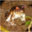

In [ ]:
imag=next(iter(datacifar))
print("The class of the image is %d,\nand the image is:"%imag[1])
imag[0]

## 2. ColorJitter Transforms

In [11]:
transform2=transforms.Compose([transforms.ColorJitter(brightness=1,contrast=0.2,saturation=0.7,hue=0.5),transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
data2=datasets.CIFAR10('/content/torch_data/', transform=transform2)

The class of the image is 6,
and the image is:


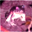

In [ ]:
imag=next(iter(data2))
print("The class of the image is %d,\nand the image is:"%imag[1])
imag[0]

## 3. RandomRotation Transforms

In [12]:
transform3=transforms.Compose([transforms.RandomRotation(degrees=180),transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
data3=datasets.CIFAR10('/content/torch_data/', transform=transform3)

The class of the image is 6,
and the image is:


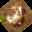

In [ ]:
imag=next(iter(data3))
print("The class of the image is %d,\nand the image is:"%imag[1])
imag[0]

## 4. Rotattion + ColorJitter Transforms

In [13]:
transform4=transforms.Compose([transforms.ColorJitter(brightness=1,contrast=0.2,saturation=0.7,hue=0.5),transforms.RandomRotation(degrees=180),transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
data4=datasets.CIFAR10('/content/torch_data/', transform=transform4)

The class of the image is 6,
and the image is:


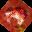

In [ ]:
imag=next(iter(data4))
print("The class of the image is %d,\nand the image is:"%imag[1])
imag[0]

## 5. Rotation + grayscale Transforms

In [14]:
transform5=transforms.Compose([transforms.RandomRotation(degrees=180),transforms.Grayscale(num_output_channels=3),transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
data5=datasets.CIFAR10('/content/torch_data/', transform=transform5)

The class of the image is 6,
and the image is:


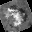

In [8]:
imag=next(iter(data5))
print("The class of the image is %d,\nand the image is:"%imag[1])
imag[0]

## Importing ResNet50 pretrained.

In [34]:
classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')

In [15]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Training Models on dataset
## 1. Model on No transformation

In [16]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
device

'cpu'

In [ ]:
!pip install pytorch_forecasting
import torch.backends.cudnn as cudnn
import torch.optim as optim
from pytorch_forecasting.optim import Ranger
import torch.nn.functional as F
import torch.nn as nn

In [70]:
from tqdm import tqdm
import gc

In [71]:
trainloader1 = torch.utils.data.DataLoader(data1, batch_size=128, shuffle=False, num_workers=2)
model=model.to(device)

if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = Ranger(model.parameters(), lr=0.01, weight_decay=5e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, cycle_momentum=False,base_lr=1e-4,max_lr=1e-3, step_size_up=2000,step_size_down=None,mode='triangular', gamma=1.0,scale_mode='cycle',base_momentum=0.8, max_momentum=0.9)
train_loss=0
correct = 0
total = 0
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader1), total=len(trainloader1), desc='Train')
    for step, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        def closure():
          optimizer.zero_grad()
          output = model(inputs)
          loss = criterion(output, targets)
          loss.backward()
          return loss
        optimizer.step(closure)
        train_loss += closure().item()
        _, predicted = model(inputs).max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        gc.collect()
        print('Loss: %.3f | Acc: %.3f%% (%d/%d)'% (train_loss/(129), 100.*correct/total, correct, total))

In [72]:
for epoch in range(150):
    train(epoch)
    scheduler.step()


Epoch: 0


Train:   0%|          | 1/391 [00:12<1:18:03, 12.01s/it]

Loss: 0.073 | Acc: 0.781% (1/128)


Train:   1%|          | 2/391 [00:22<1:13:12, 11.29s/it]

Loss: 0.167 | Acc: 0.391% (1/256)


Train:   1%|          | 2/391 [00:28<1:33:04, 14.36s/it]


KeyboardInterrupt: ignored

In [ ]:
model